# Data Description

### import libraries

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import pprint
import sklearn.datasets as datasets
from sklearn.metrics import accuracy_score, confusion_matrix
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.datasets import fetch_20newsgroups

In [8]:
from pprint import pprint
path_dataset = "/Users/yusuke_sugihara/DA_Project/07_news_Channels/"
print(os.listdir(path_dataset))


['.DS_Store', '20news-bydate-test', 'Readme.txt', '20news-bydate_py3.pkz', '20news-bydate-train']


Since our dataset is exactly the same as https://scikit-learn.org/stable/datasets/real_world.html#newsgroups-dataset, we will use the  [```The sklearn.datasets.fetch_20newsgroups function```](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html) so that we can efficiently analyze the dataset.




## Preprocessing - Data Cleaning 

In [11]:
raw_dataset = fetch_20newsgroups(subset='all', shuffle=False)
print(raw_dataset.data[1])

From: gnelson@pion.rutgers.edu (Gregory Nelson)
Subject: Thanks Apple: Free Ethernet on my C610!
Article-I.D.: pion.Apr.6.12.05.34.1993.11732
Organization: Rutgers Univ., New Brunswick, N.J.
Lines: 26


	Well, I just got my Centris 610 yesterday.  It took just over two 
weeks from placing the order.  The dealer (Rutgers computer store) 
appologized because Apple made a substitution on my order.  I ordered
the one without ethernet, but they substituted one _with_ ethernet.
He wanted to know if that would be "alright with me"!!!  They must
be backlogged on Centri w/out ethernet so they're just shipping them
with!  

	Anyway, I'm very happy with the 610 with a few exceptions.  
Being nosy, I decided to open it up _before_ powering it on for the first
time.  The SCSI cable to the hard drive was only partially connected
(must have come loose in shipping).  No big deal, but I would have been
pissed if I tried to boot it and it wouldn't come up!
	The hard drive also has an annoying high pitch

In [5]:
all_dataset = fetch_20newsgroups(
    data_home=path_dataset,
    remove=("headers", "footers", "quotes"),
    subset="all",
    shuffle=True,
    random_state=42,
)

labels = all_dataset.target
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]

print(f"{len(all_dataset.data)} documents - {true_k} categories")


3387 documents - 4 categories


In [4]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(dataset.data)
print(f'(vectors_shape:{vectors.shape}')

(vectors_shape:(3387, 33836)


In [5]:
from collections import defaultdict
from sklearn import metrics
from time import time

evaluations = []
evaluations_std = []


def fit_and_evaluate(km, X, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name

    train_times = []
    scores = defaultdict(list)
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        t0 = time()
        km.fit(X)
        train_times.append(time() - t0)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels_train, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels_train, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels_train, km.labels_))
        scores["Adjusted Rand-Index"].append(
            metrics.adjusted_rand_score(labels_train, km.labels_)
        )
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)

    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words="english",
)
t0 = time()
X_tfidf = vectorizer.fit_transform(dataset_train.data)

print(f"vectorization done in {time() - t0:.3f} s")
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

vectorization done in 0.234 s
n_samples: 2034, n_features: 7831


In [7]:
print(f"{X_tfidf.nnz / np.prod(X_tfidf.shape):.3f}")

0.012


In [8]:
from sklearn.cluster import KMeans

for seed in range(5):
    kmeans = KMeans(
        n_clusters=true_k,
        max_iter=100,
        n_init=1,
        random_state=seed,
    ).fit(X_tfidf)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Number of elements asigned to each cluster: {cluster_sizes}")
print()
print(
    "True number of documents in each category according to the class labels: "
    f"{category_sizes}"
)

Number of elements asigned to each cluster: [114 470 789 661]
Number of elements asigned to each cluster: [463 746 114 711]
Number of elements asigned to each cluster: [ 58 764 726 486]
Number of elements asigned to each cluster: [368 109 841 716]
Number of elements asigned to each cluster: [113 396 815 710]

True number of documents in each category according to the class labels: [480 584 593 377]


In [9]:
kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=5,
)

fit_and_evaluate(kmeans, X_tfidf, name="KMeans\non tf-idf vectors")

clustering done in 0.10 ± 0.01 s 
Homogeneity: 0.541 ± 0.073
Completeness: 0.615 ± 0.068
V-measure: 0.576 ± 0.071
Adjusted Rand-Index: 0.515 ± 0.100
Silhouette Coefficient: 0.010 ± 0.000


In [10]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer


lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
t0 = time()
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")


LSA done in 0.326 s
Explained variance of the SVD step: 29.2%


In [11]:
kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=1,
)

fit_and_evaluate(kmeans, X_lsa, name="KMeans\nwith LSA on tf-idf vectors")

clustering done in 0.01 ± 0.00 s 
Homogeneity: 0.579 ± 0.102
Completeness: 0.642 ± 0.075
V-measure: 0.606 ± 0.087
Adjusted Rand-Index: 0.550 ± 0.129
Silhouette Coefficient: 0.040 ± 0.002


In [12]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(
    n_clusters=true_k,
    n_init=1,
    init_size=1000,
    batch_size=1000,
)

fit_and_evaluate(
    minibatch_kmeans,
    X_lsa,
    name="MiniBatchKMeans\nwith LSA on tf-idf vectors",
)

clustering done in 0.03 ± 0.01 s 
Homogeneity: 0.551 ± 0.051
Completeness: 0.596 ± 0.052
V-measure: 0.573 ± 0.050
Adjusted Rand-Index: 0.517 ± 0.088
Silhouette Coefficient: 0.037 ± 0.003


In [13]:
original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(true_k):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]} ", end="")
    print()

Cluster 0: god com people jesus don sandvik article bible think christian 
Cluster 1: keith caltech objective morality sgi livesey solntze wpd jon schneider 
Cluster 2: graphics university thanks com files image posting host nntp help 
Cluster 3: space nasa access com henry gov digex alaska moon pat 


In [14]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

lsa_vectorizer = make_pipeline(
    HashingVectorizer(stop_words="english", n_features=50_000),
    TfidfTransformer(),
    TruncatedSVD(n_components=100, random_state=0),
    Normalizer(copy=False),
)

t0 = time()
X_hashed_lsa = lsa_vectorizer.fit_transform(dataset_train.data)
print(f"vectorization done in {time() - t0:.3f} s")

vectorization done in 1.279 s


In [15]:
fit_and_evaluate(kmeans, X_hashed_lsa, name="KMeans\nwith LSA on hashed vectors")

clustering done in 0.01 ± 0.00 s 
Homogeneity: 0.572 ± 0.069
Completeness: 0.592 ± 0.093
V-measure: 0.582 ± 0.080
Adjusted Rand-Index: 0.531 ± 0.114
Silhouette Coefficient: 0.039 ± 0.002


In [16]:
fit_and_evaluate(
    minibatch_kmeans,
    X_hashed_lsa,
    name="MiniBatchKMeans\nwith LSA on hashed vectors",
)

clustering done in 0.03 ± 0.00 s 
Homogeneity: 0.549 ± 0.072
Completeness: 0.579 ± 0.080
V-measure: 0.563 ± 0.075
Adjusted Rand-Index: 0.521 ± 0.096
Silhouette Coefficient: 0.037 ± 0.003


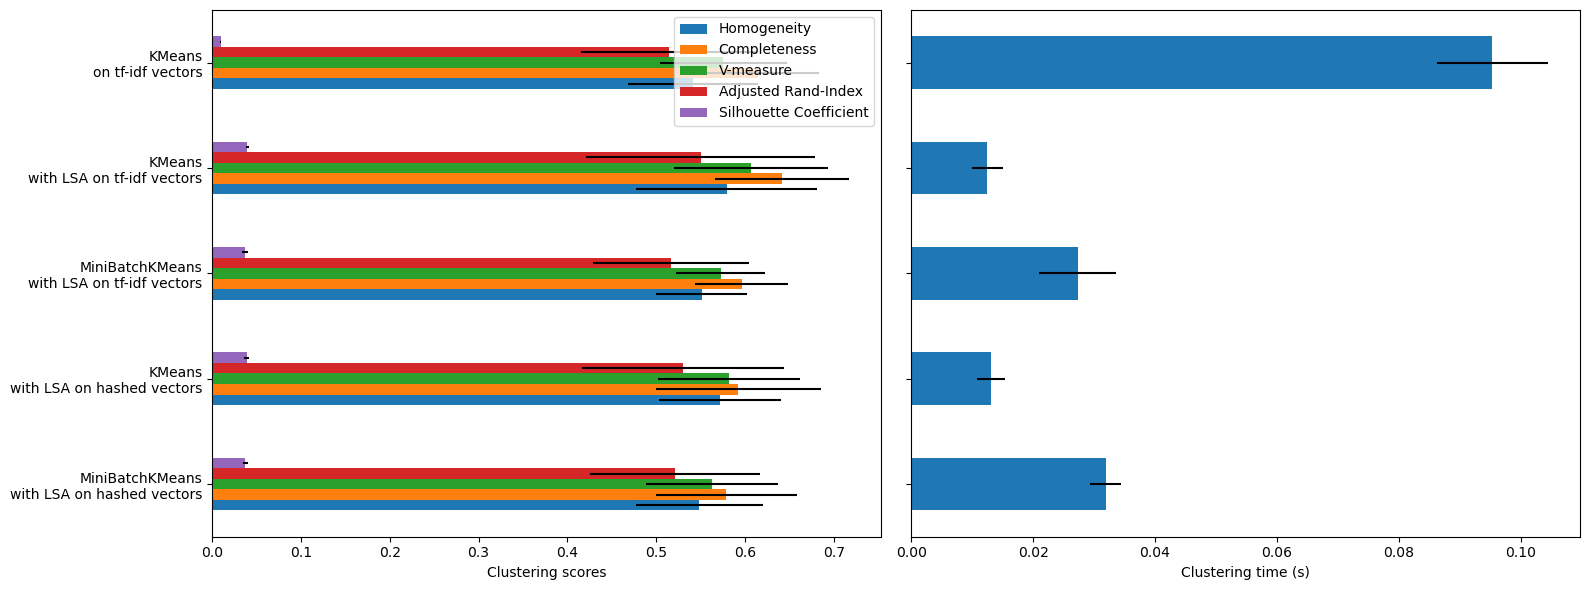

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)

df = pd.DataFrame(evaluations[::-1]).set_index("estimator")
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")

df.drop(
    ["train_time"],
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")

df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")
plt.tight_layout()